## Introduction to Yuzu

Yuzu is a compressed sensing approach for calculating feature attribution scores quickly. Here, we will see how to use Yuzu in your own code and benchmark its implementation against other approaches.

In [1]:
%pylab inline

import seaborn
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Let's start off by creating two example DNA sequences.

In [2]:
idxs = numpy.random.RandomState(0).randn(2, 4, 1000).argmax(axis=1)
X = numpy.zeros((2, 4, 1000), dtype='float32')
X[0, idxs[0], numpy.arange(1000)] = 1
X[1, idxs[1], numpy.arange(1000)] = 1

Now, let's load up one of the toy (untrained) models provided by Yuzu. As a note, these models have been extended to take in any number of categories for the input, and so can be applied to protein sequences as easily as DNA sequences, and to take in any sequence length. However, your model does not need to take in these parameters. 

In [3]:
from yuzu.models import Basset

model = Basset(n_inputs=4, seq_len=1000).eval()

The first thing we need to do is to precompute statistics about the model and the given sequence size. These include values like the receptive field and the number of probes needed at each layer. Note: because the precomputation step needs to only be done once for each model and sequence length and can then be used for any number of future sequences, the function has not yet been fully optimized and may take equivalent time to running vanilla ISM on that sequence.

We will do the precomputation on the first example sequence and then apply Yuzu to the second sequence to demonstrate that the precomputation only needs to be done once per model and sequence length.

In [4]:
from yuzu.yuzu_ism import precompute

precomputation = precompute(model, X[0:1])

Now let's apply Yuzu to the second sequence.

In [5]:
from yuzu.yuzu_ism import yuzu_ism

%timeit yuzu_ism(model, X[1:2], *precomputation, verbose=False)

922 ms ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's compare that time to the time it takes to run a naive version of ISM that treats each mutation independently.

In [6]:
from yuzu.naive_ism import naive_ism

%timeit naive_ism(model, X[1:2])

6.73 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We should also ensure that the outputs are similar.

In [7]:
yuzu_ism_scores = yuzu_ism(model, X[1:2], *precomputation, verbose=False)[0]
naive_ism_scores = naive_ism(model, X[1:2])

yuzu_ism_scores.shape, naive_ism_scores.shape

((1, 4, 1000), (1, 4, 1000))

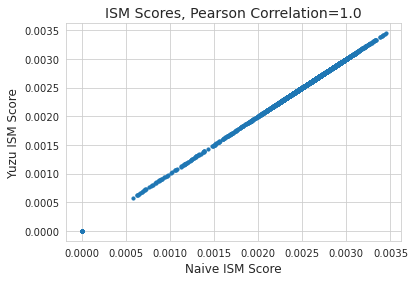

In [8]:
x = naive_ism_scores.flatten()
y = yuzu_ism_scores.flatten()
r = numpy.corrcoef(x, y)[0, 1]

plt.title("ISM Scores, Pearson Correlation={:3.3}".format(r), fontsize=14)
plt.scatter(naive_ism_scores.flatten(), yuzu_ism_scores.flatten(), s=10)
plt.xlabel("Naive ISM Score", fontsize=12)
plt.ylabel("Yuzu ISM Score", fontsize=12)
plt.show()

That's perfect correlation. Despite Yuzu being an approximate method in theory, when given enough probes (by setting alpha high enough) it is guaranteed to return an exactly correct answer, because of the principles of compressed sensing. 

Next, let's quickly look at memory usage. Many methods are able to achieve faster speeds through increased memory use. However, Yuzu actually has a bit smaller memory requirements than other approaches because it operates only on deltas and compresses those into compact probes.

In [9]:
%memit yuzu_ism(model, X[1:2], *precomputation, verbose=False)

UsageError: Line magic function `%memit` not found.


In [ ]:
%memit naive_ism(model, X[1:2])